# River/Municipality Adjacency

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from itertools import chain

import sys
sys.path.append("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code")
from data.preprocess.river_network import calculate_distance_from_estuary

In [2]:
rivers_brazil_shapefile = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/shapefile.feather")
rivers_brazil_topology = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/topology.feather")

rivers_brazil_shapefile = calculate_distance_from_estuary(rivers_brazil_shapefile, rivers_brazil_topology)

municipalities_brazil_shapefile = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/gadm/gadm41_BRA_2.json", engine="pyogrio")
municipalities_brazil_shapefile["CC_2r"] = municipalities_brazil_shapefile.CC_2.str.slice(0, 6)
#rivers_brazil_shapefile["CC_2r"] = rivers_brazil_shapefile.adm2.map(municipalities_brazil_shapefile.CC_2r.to_dict())

In [3]:
joined = rivers_brazil_shapefile.sjoin(municipalities_brazil_shapefile.to_crs(5641), how="inner")
joined.set_index(np.arange(len(joined)), append=True, inplace=True)

In [4]:
joined["len"] = joined.length
max_value_indices = joined.groupby(level=[0,1,2]).len.idxmax()

In [5]:
joined = joined.loc[max_value_indices].reset_index(level=3, drop=True)

In [6]:
# ax = municipalities_brazil_shapefile.query("CC_2r == '110010'").to_crs(5641).plot()
# tmp = joined.query("CC_2r == '110010'")
# tmp.plot(ax=ax, color="blue")
# tmp.loc[tmp.groupby(["estuary"]).distance_from_estuary.idxmin().values].plot(ax=ax, color="red")
# #rivers_brazil_shapefile[rivers_brazil_shapefile.upstream_node_id.isin([int(x) for x in test])].plot(ax=ax, color="green")

In [7]:
import shelve
reachability = shelve.open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/reachability.db")

In [8]:
analysis = joined[["upstream_node_id", "distance_from_estuary", "CC_2r"]].copy()
del joined, municipalities_brazil_shapefile, rivers_brazil_shapefile, rivers_brazil_topology

In [9]:
upstream_cc_lookup = analysis[["upstream_node_id", "CC_2r"]].dropna().astype("uint32").set_index("upstream_node_id").iloc[:,0].to_dict()
upstream_distance_lookup = analysis[["distance_from_estuary", "upstream_node_id"]].dropna().astype("uint32").set_index("upstream_node_id").iloc[:,0].to_dict()

In [10]:
def get_reachable(x):
    c_subset = x.copy()
    
    c_subset["reachable"] = c_subset.upstream_node_id.map(lambda x: reachability.get(str(int(x)), None) if not pd.isna(x) else None)
    c_subset["cc_distances"] = c_subset.reachable.apply(lambda x: {upstream_cc_lookup.get(y, None): upstream_distance_lookup.get(y, None) for y in x} if x is not None else None)
    
    out_dict = {}
    for i, row in c_subset.iterrows():
        if row.cc_distances is not None:
            for k, v in row.cc_distances.items():
                if v is not None:
                    if k == row.CC_2r:
                        continue
                    elif k not in out_dict:
                        out_dict[k] = v - row.distance_from_estuary
                    else:
                        out_dict[k] = max(out_dict[k], v - row.distance_from_estuary)

    return out_dict

In [11]:
from tqdm import tqdm
from multiprocessing import Pool

with Pool(4) as pool:
    result_list = list(tqdm(pool.imap(get_reachable, [group for name, group in analysis.groupby("CC_2r")]), total=len(analysis.groupby("CC_2r"))))

  2%|▏         | 115/5546 [00:41<48:23,  1.87it/s]  

100%|██████████| 5546/5546 [05:49<00:00, 15.87it/s] 


In [12]:
distance_matrix = {int(i): x for i, x in zip([name for name, _ in analysis.groupby("CC_2r")], result_list)}

In [13]:
municipalities = distance_matrix.keys()

In [14]:
from scipy.sparse import lil_matrix

# Create a mapping from keys to indices
key_index_lookup = {key: i for i, key in enumerate(municipalities)}

# Export mapping
pd.Series(key_index_lookup).to_frame("matrix_index").reset_index(names="cc_2r").to_csv("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/weights_municipalities.csv", index=False)

# Initialize a sparse matrix of the appropriate size
size = len(municipalities)
distance_matrix_sparse = lil_matrix((size, size))

# Populate the sparse matrix with distances
for key_from, subdict in distance_matrix.items():
    for key_to, distance in subdict.items():
        row = key_index_lookup[key_from]
        col = key_index_lookup[key_to]
        distance_matrix_sparse[row, col] = distance

# Convert to CSR format for efficient arithmetic and matrix vector operations
distance_matrix_sparse = distance_matrix_sparse.tocsr()

In [48]:
from scipy.io import mmwrite
mmwrite('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/distance_matrix.mtx', distance_matrix_sparse)

In [49]:
for max_distance in [100, 500, 1000]:
    for method in ["linear", "exponential"]:
        # Function to convert distance to weight
        def distance_to_weight(distance, method="linear", max_distance=1000000):
            if distance > max_distance:
                return 0
            if method == "linear":
                return 1 - (distance / max_distance)
            if method == "exponential":
                return np.exp(-distance / max_distance)

        # Apply the distance to weight conversion
        weights_matrix_sparse = distance_matrix_sparse.copy()
        weights_matrix_sparse.data = np.array([distance_to_weight(d, method, max_distance * 1e3) for d in weights_matrix_sparse.data])

        # Normalize the weights
        weights_matrix_sparse = weights_matrix_sparse.multiply(1 / weights_matrix_sparse.sum(axis=1))

        from scipy.io import mmwrite
        mmwrite(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/weights_matrix_{method}_{max_distance}.mtx", weights_matrix_sparse)


/scratch/slurm_tmpdir/job_23823722/ipykernel_329180/1276763093.py:17: RuntimeWarning: divide by zero encountered in divide
  weights_matrix_sparse = weights_matrix_sparse.multiply(1 / weights_matrix_sparse.sum(axis=1))
/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/setup/miniforge3/envs/thesis/lib/python3.9/site-packages/scipy/sparse/_compressed.py:472: RuntimeWarning: invalid value encountered in multiply
  data = np.multiply(ret.data, other[ret.row].ravel())


<Axes: >

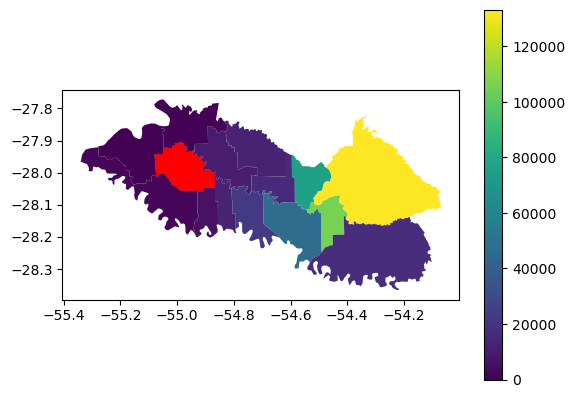

In [317]:
c_mun = municipalities[5000]
test = distance_matrix[c_mun]
test = {str(i): x for i, x in test.items() if x is not None}

test_subset = boundaries.set_index("CC_2r").loc[test.keys()]
test_subset["weight"] = test.values()

ax = test_subset.plot(column="weight", legend=True)
boundaries.set_index("CC_2r").loc[[str(c_mun)]].plot(ax=ax, color="red")

In [134]:
pd.DataFrame(distance_matrix).to_csv("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/analysis/distance_matrix.csv", index=False, header=False)

In [135]:
def create_weights_matrix(distance_matrix):
    municipalities = list(distance_matrix.keys())
    num_municipalities = len(municipalities)
    weights_matrix = np.zeros((num_municipalities, num_municipalities))

    for i, c_mun in enumerate(municipalities):
        for j, t_mun in enumerate(municipalities):
            distance = distance_matrix[c_mun][t_mun]
            if distance is not None and distance > 0:
                weights_matrix[i][j] = 1 / distance
            else:
                weights_matrix[i][j] = 0  # No self-weight

    # Normalize the weights matrix row-wise
    row_sums = weights_matrix.sum(axis=1)
    weights_matrix = np.divide(weights_matrix, row_sums[:, np.newaxis], where=row_sums[:, np.newaxis] != 0)

    return weights_matrix

# Example usage
weights_matrix = create_weights_matrix(distance_matrix)


In [138]:
from scipy.io import mmwrite, mmread
from scipy.sparse import csr_matrix

# Assuming weights_matrix is your numpy matrix, convert it to a sparse matrix
weights_matrix_sparse = csr_matrix(weights_matrix)

# Save the sparse matrix to a .mtx file
mmwrite('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/weights_matrix.mtx', weights_matrix_sparse)


In [69]:
pd.DataFrame(weights_matrix).to_csv("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/analysis/weights_matrix.csv", index=False, header=False)

In [70]:
pd.DataFrame(weights_matrix)

,0,1,2,3,4,5,6,7,8,9,...,5549,5550,5551,5552,5553,5554,5555,5556,5557,5558
0,0.0,0.008741,0.010097,0.019994,0.017555,0.006894,0.008749,0.007373,0.005616,0.007195,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.047747,0.000000,0.068975,0.022994,0.059519,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
2,0.0,0.077575,0.000000,0.000000,0.000000,0.025894,0.078061,0.032572,0.015079,0.029823,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
3,0.0,0.008061,0.010588,0.000000,0.074692,0.005461,0.008073,0.006063,0.004053,0.005833,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
4,0.0,0.002879,0.003930,0.000000,0.000000,0.001877,0.002884,0.002102,0.001365,0.002016,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5554,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000695,0.000285,0.000301,0.000327,0.000684,0.00000,0.000831,0.000847,0.002445,0.0
5555,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010525,0.001069,0.001165,0.001333,0.009552,0.00000,0.000000,0.000000,0.000000,0.0
5556,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000021,0.000002,0.000003,0.000003,0.000019,0.00000,0.000239,0.000000,0.000000,0.0
5557,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002998,0.000994,0.001059,0.001166,0.002930,0.00000,0.003884,0.003997,0.000000,0.0


In [20]:
municipalities_estuaries.reset_index("adm2").loc[136]

,adm2,distance_from_estuary
estuary,,
136.0,0.0,3.616017e+06
136.0,1.0,4.539743e+06
136.0,2.0,4.415703e+06
136.0,3.0,4.019874e+06
136.0,4.0,4.075983e+06
...,...,...
136.0,4413.0,2.659438e+06
136.0,4414.0,2.335886e+06
136.0,4415.0,2.336068e+06


In [17]:
municipalities_estuaries.reset_index("adm2").apply(lambda x: {x.adm2: x.distance_from_estuary}, axis=1)

estuary
136.0       {0.0: 3616017.0561254765}
136.0         {1.0: 4539742.78276892}
136.0        {2.0: 4415703.394487375}
136.0        {3.0: 4019874.492434661}
136.0       {4.0: 4075983.2249229294}
                     ...             
19.0      {5567.0: 979172.6525189149}
19.0     {5568.0: 1364380.3696084176}
19.0     {5569.0: 1357161.7499743742}
19.0     {5570.0: 1110085.2460516596}
19.0      {5571.0: 965156.2489057605}
Length: 7833, dtype: object

In [11]:
municipalities_estuaries.to_dict()

{(0.0, 136.0): 3616017.0561254765,
 (1.0, 136.0): 4539742.78276892,
 (2.0, 136.0): 4415703.394487375,
 (3.0, 136.0): 4019874.492434661,
 (4.0, 136.0): 4075983.2249229294,
 (5.0, 136.0): 4787310.612326235,
 (6.0, 136.0): 4538970.868117289,
 (7.0, 136.0): 4711118.51798952,
 (8.0, 136.0): 5053813.420634858,
 (9.0, 136.0): 4738348.3866598485,
 (10.0, 136.0): 4598513.918406607,
 (11.0, 136.0): 5132916.301983601,
 (12.0, 136.0): 3712892.8384870254,
 (13.0, 136.0): 3941118.949352425,
 (14.0, 136.0): 4856876.710835303,
 (15.0, 136.0): 4284402.559950981,
 (16.0, 136.0): 4793833.216446434,
 (17.0, 136.0): 4915478.651755221,
 (18.0, 136.0): 4612030.743830219,
 (19.0, 136.0): 4034849.066026817,
 (20.0, 136.0): 4971251.838002663,
 (21.0, 136.0): 4269818.894440165,
 (22.0, 471.0): 445419.2031051623,
 (23.0, 347.0): 63076.409539157896,
 (23.0, 480.0): 59544.6715519536,
 (24.0, 202.0): 86936.4816110855,
 (24.0, 471.0): 189785.75946170243,
 (25.0, 25.0): 83912.68168128503,
 (25.0, 396.0): 28401.8513432

In [7]:
test.groupby("adm2").count().value_counts()

distance_from_estuary
1     4383
2      790
3      193
4       72
5       36
6       25
7       21
8       11
12       5
9        4
10       3
16       2
23       2
14       2
15       2
20       2
11       2
34       1
26       1
33       1
21       1
Name: count, dtype: int64

In [4]:
import json
with open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/reachability.json", "r") as f:
    reachability = json.load(f)

In [5]:
nodes_municipalities = joined.groupby("GID_2").upstream_node_id.unique()

In [8]:
reachability_municipalities = nodes_municipalities.apply(lambda x: list(set(chain(*[reachability.get(str(y), []) for y in x]))))

In [13]:
reachability_municipalities.to_json("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/reachability_municipalities.json")

In [184]:
brazil_total = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/gadm/gadm41_BRA_0.json", engine="pyogrio")

<Axes: >

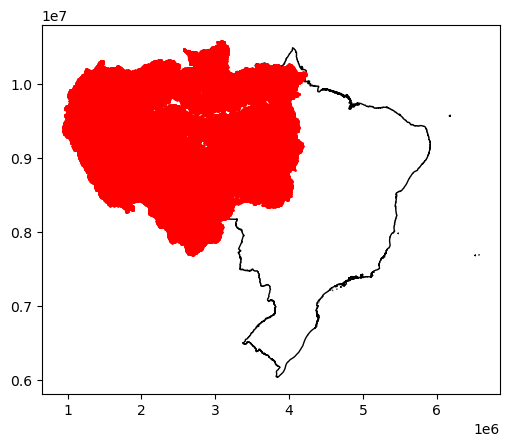

In [185]:
from itertools import chain
ax = municipalities_brazil_shapefile.query(f"GID_2=='BRA.3.7_2'").to_crs(5641).plot(markersize = 10)
brazil_total.to_crs(5641).plot(ax=ax, color="none", edgecolor="black")
rivers_brazil_topology.loc[reachability_municipalities['BRA.3.7_2']].plot(ax=ax, markersize=1, color="red")


---

# Polygon Extraction

In [1]:
import pickle
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code")
from data.preprocess.drainage_polygons.aux_functions import expand_bounds, load_height_profile

In [2]:
# connect to database
conn = sqlite3.connect('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/imagery.db')
# get grid data
grid_data = pd.read_sql_query("SELECT * FROM GridCells WHERE Internal=1", conn)
# get grid geometries
grid_geoms = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/grid_cells.feather")
# merge data
grid_data = gpd.GeoDataFrame(grid_data.merge(grid_geoms, on = "CellID"))
# close connection
conn.close()

In [3]:
rivers_brazil_shapefile = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/river_network/shapefile.feather")
drainage_polygons = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/drainage_polygons_dissolved_filtered.feather")
drainage_polygons_dissolved = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/drainage_polygons_dissolved_filtered.feather").reset_index(drop=True)

In [4]:
import os
files = os.listdir("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/temp_extracted_grid_cells")
files = pd.Series(files).str.extract(r"(\d*)").squeeze().astype(int).unique()
np.array([file for file in grid_data.index if file not in files and drainage_polygons.centroid.intersects(grid_data.iloc[[file]].to_crs(4326).iloc[0].geometry).any()])

array([375, 376])

In [96]:
files = os.listdir("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/temp_extracted_grid_cells")
files = pd.Series(files).str.extract(r"(\d*)").squeeze().astype(int).unique()

extracted_drainage_polygons = {i: pd.concat(pickle.load(open(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/temp_extracted_grid_cells/{i}.pkl", "rb"))).reset_index(drop=True) for i in files}
extracted_drainage_polygons = pd.concat(extracted_drainage_polygons)
extracted_drainage_polygons.to_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/extracted_drainage_polygons.feather")

---

In [14]:
# import drainage polygons
extracted_drainage_polygons = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/extracted_drainage_polygons.feather")
extracted_drainage_polygons = extracted_drainage_polygons.set_crs(4326)[~extracted_drainage_polygons.is_empty].dropna(subset=["geometry"])

In [15]:
extracted_drainage_polygons

estuary    river  segment  subsegment  distance_from_estuary  \
602  0       136.0  41388.0      0.0         0.0              3468000.0   
     1       136.0  41388.0      0.0         0.0              3467000.0   
     12      136.0  41388.0      1.0         0.0              3469000.0   
     14      136.0  41463.0      0.0         0.0              3420000.0   
     15      136.0  41463.0      0.0         0.0              3419000.0   
...            ...      ...      ...         ...                    ...   
1022 1517     29.0    170.0      0.0         0.0               328000.0   
     1518     29.0    170.0      0.0         0.0               327000.0   
     1519     29.0    170.0      0.0         0.0               326000.0   
     1520     29.0    170.0      0.0         0.0               325000.0   
     1521     29.0    170.0      0.0         0.0               324000.0   

                                                    geometry  
602  0     MULTIPOLYGON (((-62.57772 -12.67584, -62.57712...  
     1     POLYGON ((-62.50037 -12.68141, -62.49949 -12.6...  
     12    LINESTRING (-62.50992 -12.67658, -62.50958 -12...  
     14    POLYGON ((-62.59708 -12.66958, -62.59708 -12.6...  
     15    MULTIPOLYGON (((-62.60625 -12.65792, -62.60542...  
...                                                      ...  
1022 1517  POLYGON ((-53.80042 -32.61875, -53.80042 -32.6...  
     1518  POLYGON ((-53.81542 -32.61958, -53.81625 -32.6...  
     1519  POLYGON ((-53.83375 -32.61792, -53.83458 -32.6...  
     1520  POLYGON ((-53.80375 -32.62292, -53.80375 -32.6...  
     1521  GEOMETRYCOLLECTION (POINT (-53.94517 -32.43767...  

[1171403 rows x 6 columns]

In [27]:
year = 1985
grid_id = 269

In [18]:
import shapely

In [23]:
shapely.box(*extracted_drainage_polygons.loc[525].total_bounds).area

1.3704458790744247

In [28]:
from tqdm import tqdm
test = []
for year in tqdm(range(1985, 2023)):
    lc_t = rxr.open_rasterio(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/lc_mapbiomas8_30/mapbiomas_brasil_coverage_{year}.tif", chunks=True).squeeze()
    test.append(lc_t.rio.clip_box(*expand_bounds(extracted_drainage_polygons.loc[grid_id].total_bounds)).load())

100%|██████████| 38/38 [00:14<00:00,  2.64it/s]


In [31]:
polygons_raster = pickle.load(open(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/temp_extraction_masks/{grid_id}.pkl", "rb"))

In [36]:
    # extract data
    c_extracted = {}
    for year in range(1985, 2023):
        # extract raw pixel values
        c_extracted[year] = {i: test[year-1985].values[polygons_raster[i].astype(bool).todense()] for i in tqdm(range(len(polygons_raster)))}
    

 61%|██████▏   | 573/933 [00:11<00:07, 50.35it/s]

KeyboardInterrupt: 

 61%|██████▏   | 573/933 [00:27<00:07, 50.35it/s]

In [35]:
%timeit polygons_raster[i].astype(bool).todense()

12.5 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
i = 0
test[0].values[polygons_raster[i].astype(bool)]

RuntimeError: Cannot convert a sparse array to dense automatically. To manually densify, use the todense method.

In [30]:
test[0]

<xarray.DataArray (y: 5818, x: 6286)> Size: 37MB
array([[ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       ...,
       [ 6,  6, 33, ...,  3,  3,  3],
       [ 6,  6, 33, ...,  3,  3,  3],
       [ 6,  6,  6, ...,  3,  3,  3]], dtype=uint8)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 50kB -64.51 -64.51 -64.51 ... -62.82 -62.82 -62.82
  * y            (y) float64 47kB -4.338 -4.338 -4.339 ... -5.905 -5.906 -5.906
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [10]:
test.nbytes / 1000 / 1000

42.474072

In [9]:
sizes.sort_values(ascending=False)

331    2877
788    2720
332    2673
287    2511
648    2495
       ... 
182       8
685       7
926       2
521       2
0         1
Length: 1006, dtype: int64

In [5]:
extracted_drainage_polygons

estuary    river  segment  subsegment  distance_from_estuary  \
602  0       136.0  41388.0      0.0         0.0              3468000.0   
     1       136.0  41388.0      0.0         0.0              3467000.0   
     12      136.0  41388.0      1.0         0.0              3469000.0   
     14      136.0  41463.0      0.0         0.0              3420000.0   
     15      136.0  41463.0      0.0         0.0              3419000.0   
...            ...      ...      ...         ...                    ...   
1022 1517     29.0    170.0      0.0         0.0               328000.0   
     1518     29.0    170.0      0.0         0.0               327000.0   
     1519     29.0    170.0      0.0         0.0               326000.0   
     1520     29.0    170.0      0.0         0.0               325000.0   
     1521     29.0    170.0      0.0         0.0               324000.0   

                                                    geometry  
602  0     MULTIPOLYGON (((-62.57772 -12.67584, -62.57712...  
     1     POLYGON ((-62.50037 -12.68141, -62.49949 -12.6...  
     12    LINESTRING (-62.50992 -12.67658, -62.50958 -12...  
     14    POLYGON ((-62.59708 -12.66958, -62.59708 -12.6...  
     15    MULTIPOLYGON (((-62.60625 -12.65792, -62.60542...  
...                                                      ...  
1022 1517  POLYGON ((-53.80042 -32.61875, -53.80042 -32.6...  
     1518  POLYGON ((-53.81542 -32.61958, -53.81625 -32.6...  
     1519  POLYGON ((-53.83375 -32.61792, -53.83458 -32.6...  
     1520  POLYGON ((-53.80375 -32.62292, -53.80375 -32.6...  
     1521  GEOMETRYCOLLECTION (POINT (-53.94517 -32.43767...  

[1171403 rows x 6 columns]

In [103]:
extracted_drainage_polygons.index.get_level_values(0).unique()
# create chunks of 10
chunks = np.array_split(extracted_drainage_polygons.index.get_level_values(0).unique(), 10)

In [ ]:
pd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/temp_extracted_land_cover/129.feather")

In [7]:
legend = pd.read_excel("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/legend/mapbiomas_legend.xlsx")

In [11]:
class_labels = {
    "forest": legend.loc[legend.Class.str.match(r"(^1\.)"), "ID"].values,
    "non-forest/natural": legend.loc[legend.Class.str.match(r"(^2\.)"), "ID"].values,
    "farming": legend.loc[legend.Class.str.match(r"(^3\.)"), "ID"].values,
    "pasture": legend.loc[legend.Class.str.match(r"(^3\.1)"), "ID"].values,
    "agriculture": legend.loc[legend.Class.str.match(r"(^3\.2)"), "ID"].values,
    "non-vegetated": legend.loc[legend.Class.str.match(r"(^4\.)"), "ID"].values,
    "urban": legend.loc[legend.Class.str.match(r"(^4\.2)"), "ID"].values,
    "mining": legend.loc[legend.Class.str.match(r"(^4\.3)"), "ID"].values,
    "water": legend.loc[legend.Class.str.match(r"(^5\.)"), "ID"].values,
    }

In [ ]:
# two approaches:
# 1. sum of area
# 2. count deforestation events

In [26]:
c_extracted = {}

In [14]:
polygons_raster = pickle.load(open(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage/temp_extraction_masks/{grid_id}.pkl", "rb"))

In [28]:
grid_id = 525
indices = extracted_drainage_polygons.loc[grid_id].index

In [101]:
lc_t

<xarray.DataArray (y: 158459, x: 155239)> Size: 25GB
dask.array<getitem, shape=(158459, 155239), dtype=uint8, chunksize=(11264, 11264), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 1MB -74.9 -74.9 -74.9 ... -33.06 -33.06 -33.06
  * y            (y) float64 1MB 7.912 7.912 7.911 ... -34.79 -34.79 -34.79
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [63]:
def extract(x, x_1):
    #
    land_cover = np.unique(x, return_counts=True)
    #
    df_g = np.sum(np.isin(x_1, class_labels["forest"]) & (~ np.isin(x, class_labels["forest"])))
    df_f = np.sum(np.isin(x_1, class_labels["forest"]) & (np.isin(x, class_labels["farming"])))
    df_p = np.sum(np.isin(x_1, class_labels["forest"]) & (np.isin(x, class_labels["pasture"])))
    df_a = np.sum(np.isin(x_1, class_labels["forest"]) & (np.isin(x, class_labels["agriculture"])))
    df_u = np.sum(np.isin(x_1, class_labels["forest"]) & (np.isin(x, class_labels["urban"])))
    df_m = np.sum(np.isin(x_1, class_labels["forest"]) & (np.isin(x, class_labels["mining"])))
    deforestation = np.array([df_g, df_f, df_p, df_a, df_u, df_m])
    #
    return land_cover, deforestation

In [ ]:
for year in range(1985, 2023):
    # load land cover data
    lc_t = rxr.open_rasterio(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/lc_mapbiomas8_30/mapbiomas_brasil_coverage_{year}.tif", chunks=True).squeeze()
    # clip land cover data
    lc_t_subset = lc_t.rio.clip_box(*expand_bounds(extracted_drainage_polygons.loc[grid_id].total_bounds))
    # extract raw pixel values
    c_extracted[year] = {i: lc_t_subset.values[polygons_raster[i].astype(bool).todense()] for i in range(len(polygons_raster))}

In [ ]:
for year in range(1986, 2023):
    # calculate land cover and deforestation data
    c_extracted_processed = [extract(c_extracted[year][i], c_extracted[year-1][i]) for i in range(len(polygons_raster))]
    
    ## post-process land cover data
    # prepare dataframe
    lc_df = pd.DataFrame(columns = legend.ID, index = extracted_drainage_polygons.loc[grid_id].index)
    # fill dataframe
    for i in range(len(c_extracted_processed)):
        lc_df.loc[indices[i], c_extracted_processed[i][0][0]] = c_extracted_processed[i][0][1]
    # fill missing values with 0 and calculate total area 
    lc_df = lc_df.fillna(0)
    lc_df["total"] = lc_df.sum(axis=1)

    # sum columns based on IDs and create new columns with names from the dictionary
    for name, id_ in class_labels.items():
        lc_df[name] = lc_df[id_].sum(axis=1)
        
    ## post-process deforestation data
    df_df = pd.DataFrame().from_dict({indices[i]: c_extracted_processed[i][1] for i in range(len(c_extracted_processed))}, 
                                    orient = "index",
                                    columns = ["deforestation", "deforestation_f", "deforestation_p", "deforestation_a", "deforestation_u", "deforestation_m"])
    
    # merge dataframes
    out_df = pd.concat([lc_df, df_df], axis=1)
    # add year and grid_id
    out_df["year"] = year; out_df["grid_id"] = grid_id
    # set index
    out_df = out_df.reset_index().set_index(["grid_id", "index"])

In [98]:
out_df

1      3  4  5  6  49  10  11  12  32  ...  mining  water  \
grid_id index                                         ...                  
525     2      0   5208  0  0  0   0   0   0   0   0  ...       0      0   
        3      0    296  0  0  0   0   0   0   0   0  ...       0      0   
        4      0   6406  0  0  0   0   0   0   0   0  ...       0      0   
        5      0   9067  0  0  0   0   0   0   0   0  ...       0      0   
        6      0  16870  0  0  0   0   0   0   0   0  ...       0      0   
...           ..    ... .. .. ..  ..  ..  ..  ..  ..  ...     ...    ...   
        2512   0   1460  0  0  0   0   0   0   0   0  ...       0      0   
        2515   0     13  0  0  0   0   0   0   0   0  ...       0      0   
        2516   0    126  0  0  0   0   0   0   0   0  ...       0      0   
        2517   0   2058  0  0  0   0   0   0   0   0  ...       0      0   
        2519   0  26550  0  0  0   0   0   0   0   0  ...       0      0   

               forest_share  deforestation  deforestation_f  deforestation_p  \
grid_id index                                                                  
525     2          0.981345              8                8                8   
        3          1.000000              0                0                0   
        4          0.993640             10               10               10   
        5          0.979263             14               14               14   
        6          0.989733             13               13               13   
...                     ...            ...              ...              ...   
        2512       1.000000              0                0                0   
        2515       1.000000              0                0                0   
        2516       1.000000              0                0                0   
        2517       1.000000              0                0                0   
        2519       0.978982             16               16               16   

               deforestation_a  deforestation_u  deforestation_m  year  
grid_id index                                                           
525     2                    0                0                0  1992  
        3                    0                0                0  1992  
        4                    0                0                0  1992  
        5                    0                0                0  1992  
        6                    0                0                0  1992  
...                        ...              ...              ...   ...  
        2512                 0                0                0  1992  
        2515                 0                0                0  1992  
        2516                 0                0                0  1992  
        2517                 0                0                0  1992  
        2519                 0                0                0  1992  

[1260 rows x 57 columns]

In [89]:
extracted_drainage_polygons.loc[grid_id]

,estuary,river,segment,subsegment,distance_from_estuary,geometry
2,136.0,44849.0,0.0,0.0,3157000.0,"POLYGON ((-68.41875 -10.91208, -68.41875 -10.9..."
3,136.0,44849.0,0.0,0.0,3156000.0,"POLYGON ((-68.39875 -10.90792, -68.39792 -10.9..."
4,136.0,44849.0,0.0,0.0,3155000.0,"POLYGON ((-68.40542 -10.89625, -68.40542 -10.8..."
5,136.0,44849.0,0.0,0.0,3154000.0,"POLYGON ((-68.37958 -10.89292, -68.37875 -10.8..."
6,136.0,44849.0,0.0,0.0,3153000.0,"POLYGON ((-68.44030 -10.92890, -68.43951 -10.9..."
...,...,...,...,...,...,...
2512,136.0,30884.0,0.0,0.0,4087000.0,"MULTIPOLYGON (((-68.46208 -10.09875, -68.46208..."
2515,136.0,30884.0,0.0,0.0,4084000.0,"POLYGON ((-68.40958 -10.05842, -68.40958 -10.0..."
2516,136.0,30884.0,0.0,0.0,4083000.0,"POLYGON ((-68.40514 -10.05378, -68.40485 -10.0..."
2517,136.0,30884.0,0.0,0.0,4082000.0,"MULTIPOLYGON (((-68.61075 -10.24741, -68.61114..."


In [86]:
test = extracted_drainage_polygons.loc[grid_id].join(out_df)

<Axes: >

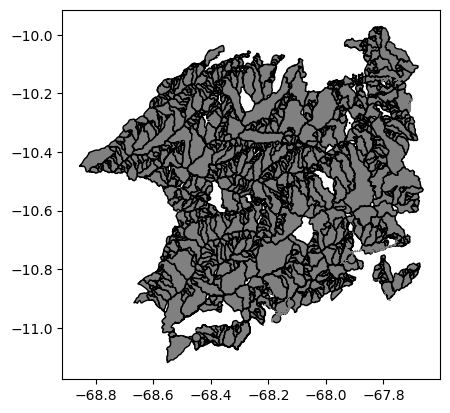

In [79]:
test.plot(color="grey", edgecolor="black")

In [67]:
polygons_raster = [rasterize_polygon(x, lc_t_subset.shape) for x in list(zip(polygons.geometry, polygons.index))]

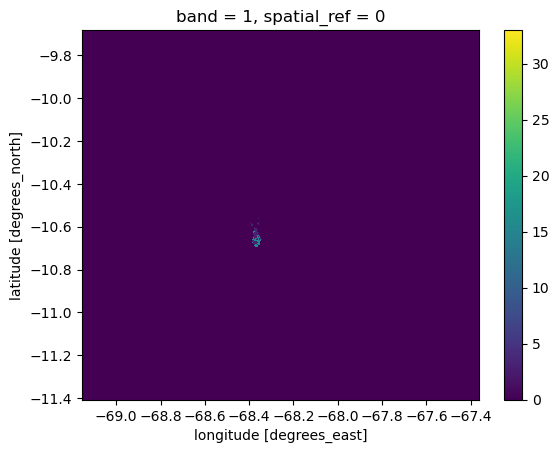

In [70]:
xr.DataArray(lc_t_subset * polygons_raster[500].todense()).plot.imshow()

In [13]:
lc_t_subset * test

<xarray.DataArray (y: 6389, x: 6648)> Size: 42MB
dask.array<mul, shape=(6389, 6648), dtype=uint8, chunksize=(4098, 5430), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 53kB -69.15 -69.15 -69.15 ... -67.36 -67.36 -67.36
  * y            (y) float64 51kB -9.684 -9.684 -9.685 ... -11.41 -11.41 -11.41
    spatial_ref  int64 8B 0

In [266]:
# extract land cover information
t_out_list = {}
for idx in polygons.index:
    # get polygon
    c_polygon = polygons.iloc[idx].geometry
    # check if polygon is empty or irregularly small
    if c_polygon is None:
        continue
    elif c_polygon.is_empty or c_polygon.area < 1e-15:
        continue
    # clip to polygon
    t_lc_t_clip = lc_t_subset.rio.clip_box(*expand_bounds(c_polygon.bounds)).rio.clip([c_polygon])
    t_lc_t_1_clip = lc_t_1_subset.rio.clip_box(*expand_bounds(c_polygon.bounds)).rio.clip([c_polygon])
    # get unique counts
    t_counts = np.unique(t_lc_t_clip, return_counts=True)
    t_counts = pd.Series(t_counts[1], index=t_counts[0])
    
    t_events = pd.Series(
        [
            (t_lc_t_1_clip.isin(class_labels["forest"]) & ~ t_lc_t_clip.isin(class_labels["forest"])).sum().values,
            (t_lc_t_1_clip.isin(class_labels["forest"]) & t_lc_t_clip.isin(class_labels["pasture"])).sum().values,
            (t_lc_t_1_clip.isin(class_labels["forest"]) & t_lc_t_clip.isin(class_labels["agriculture"])).sum().values,
            (t_lc_t_1_clip.isin(class_labels["forest"]) & t_lc_t_clip.isin(class_labels["urban"])).sum().values,
            (t_lc_t_1_clip.isin(class_labels["forest"]) & t_lc_t_clip.isin(class_labels["mining"])).sum().values
        ],
        index=["deforestation", "to_pasture", "to_agriculture", "to_urban", "to_mining"]
    )
    
    # get deforestation events
    t_out_list |= {idx: pd.concat([t_counts, t_events]).to_dict()}

In [228]:
c_sums = pd.DataFrame.from_dict(t_counts_list, orient="index")
c_sums = polygons.join(c_sums)

In [242]:
# Compute the sum of each set of columns
sums = {}
for name, columns in class_labels.items():
    present_columns = [col for col in columns if col in c_sums.columns]
    if present_columns:
        sums[name] = c_sums[present_columns].sum(axis=1)
# Convert the sums dictionary to a DataFrame if needed
sums_df = pd.DataFrame(sums)

In [249]:
means_df = pd.Series(sums_df.forest / sums_df.sum(axis=1), name="forest_share")

<Axes: >

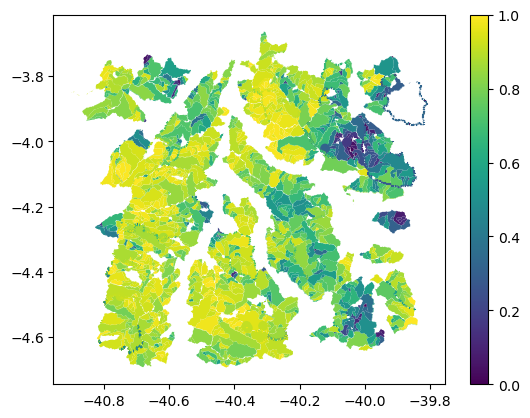

In [251]:
polygons.join(means_df).plot(column="forest_share", legend=True)

In [172]:
pd.DataFrame(t_counts_series).T

,0,3
0,102218,124


In [157]:
pd.Series(zip(*np.unique(lc_t.rio.clip_box(*c_polygon.bounds).rio.clip([c_polygon]), return_counts=True)))

0    (0, 102218)
1       (3, 124)
dtype: object

In [110]:
compare_pasture = compare.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds).isin(class_labels["pasture"]) * 2
compare_agriculture = compare.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds).isin(class_labels["agriculture"]) * 3
compare_urban = compare.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds).isin(class_labels["urban"]) * 4
compare_mining = compare.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds).isin(class_labels["mining"]) * 5

In [116]:
(baseline_forest * compare_pasture).any().values

array(True)

In [124]:
(baseline_forest * compare_agriculture).sum().values

array(447)

In [125]:
from matplotlib.colors import ListedColormap

# Your dictionary of ranges and RGB values
custom_colors = {
    (0, 1): "#FFFFFF",
    (1, 2): "#edde8e",
    (2, 3): "#E974ED",
    (3, 4): "#d4271e",
    (4, 5): "#9c0027",
}

# Creating the custom colormap
colors = []
for key in sorted(custom_colors.keys()):
    colors.append(custom_colors[key])
cmap = ListedColormap(colors)

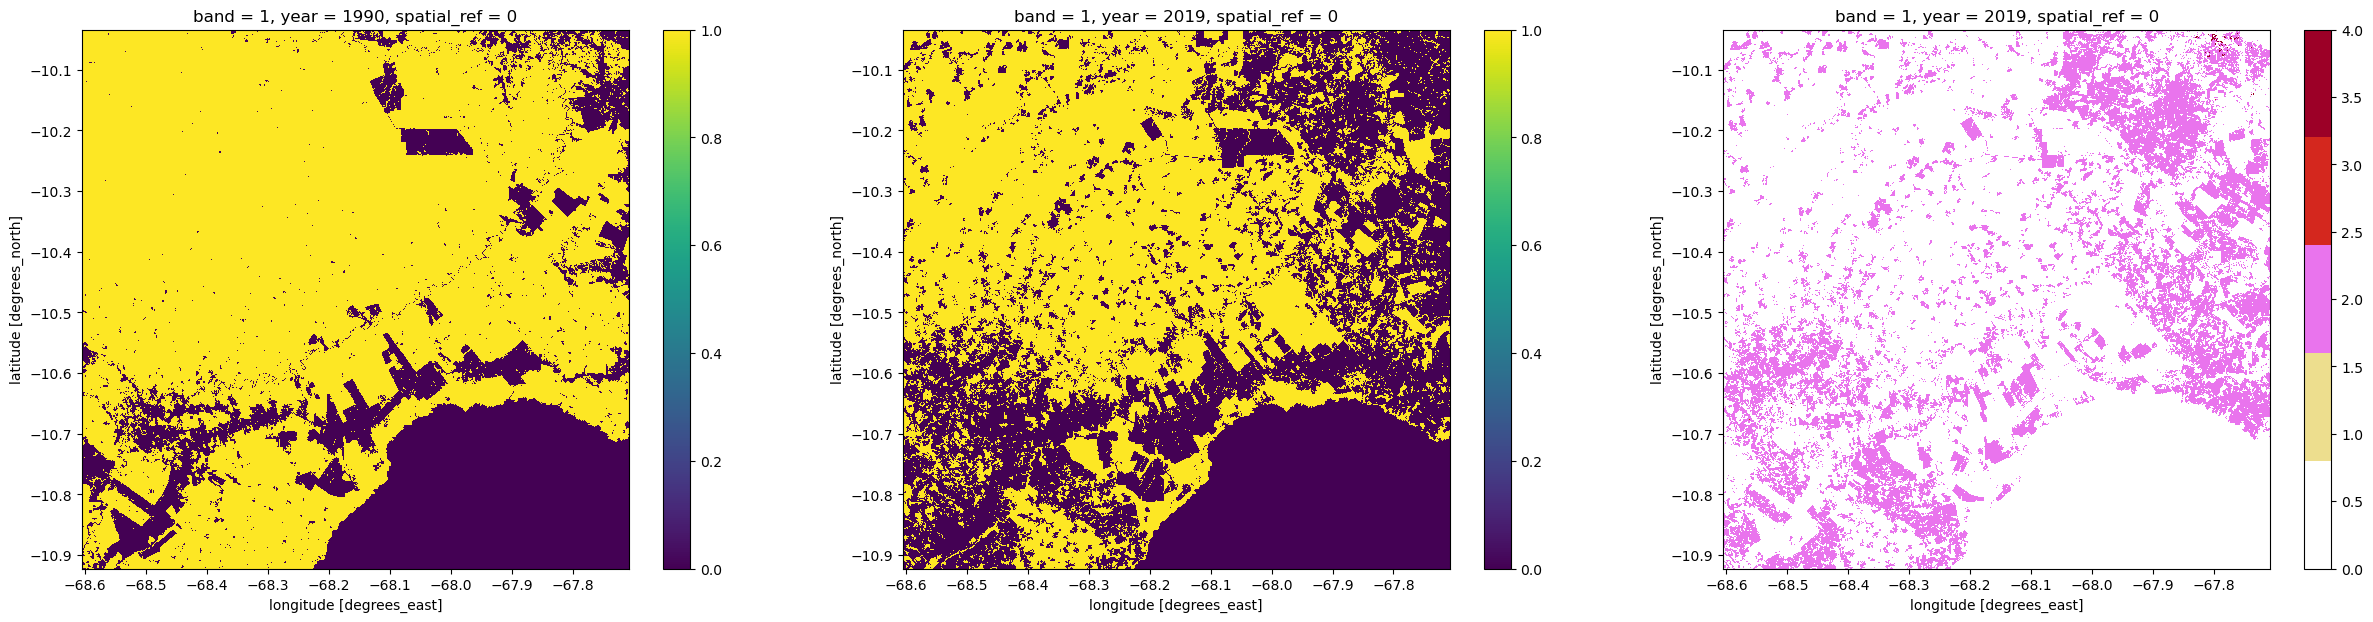

In [127]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(30, 7))

baseline_forest = baseline.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds).isin(class_labels["forest"]).squeeze()
baseline_forest.plot.imshow(ax=ax[0])
compare_forest = compare.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds).isin(class_labels["forest"]).squeeze()
compare_forest.plot.imshow(ax=ax[1])
(baseline_forest * compare_pasture + baseline_forest * compare_agriculture + baseline_forest * compare_urban + baseline_forest * compare_mining).squeeze().plot.imshow(ax=ax[2], cmap = cmap)

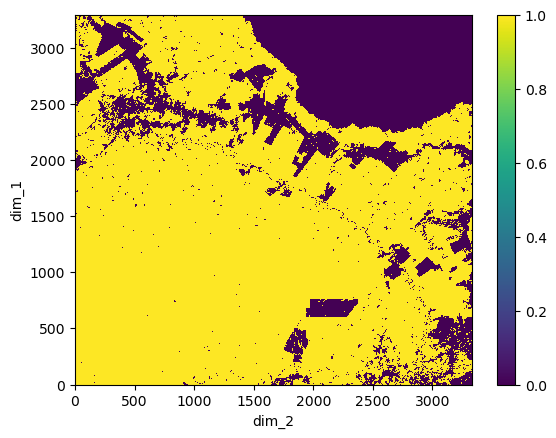

In [90]:
xr.DataArray(np.isin(baseline.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds), )).squeeze().plot.imshow()

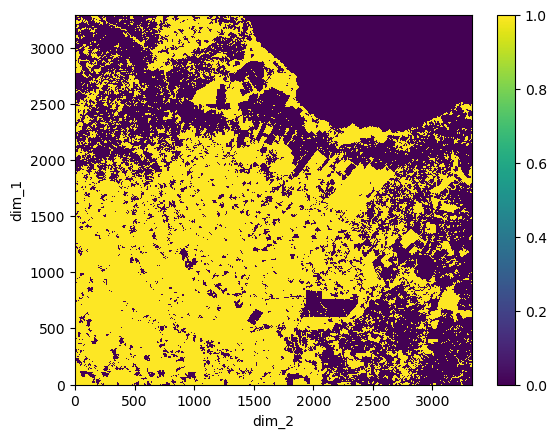

In [91]:
xr.DataArray(np.isin(compare.rio.clip_box(*grid_data.iloc[[525]].to_crs(4326).total_bounds), legend.loc[legend.Class.str.match(r"(^1\.)"), "ID"].values)).squeeze().plot.imshow()

In [61]:
for i in [525]:
    c_subset = drainage_polygons.loc[drainage_polygons.centroid.intersects(grid_data.iloc[[525]].to_crs(4326).iloc[0].geometry, align = False),:]
    
    c_height_profile = load_height_profile(expand_bounds(c_subset.total_bounds))

In [35]:
gpd.clip(drainage_polygons, )

/scratch/slurm_tmpdir/job_23545835/ipykernel_303374/3219030062.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gpd.clip(drainage_polygons, grid_data.iloc[[525]].to_crs(4326).centroid)


,estuary,river,geometry
8740,136.0,30901.0,POINT (-68.15655 -10.47820)


---

# Health

In [1]:
import pandas as pd

In [19]:
# load and combine data
scraping_results = [pd.read_csv(f"/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/mortality/raw/scraping_{t}_1996.csv") for t in ["pre", "post"]]
scraping_results = pd.concat(scraping_results)
# turn into long format
scraping_results = scraping_results.melt(id_vars=["mun_id", "mun_name", "year"], var_name="age_group", value_name="deaths")

In [76]:
# load data
population = pd.read_csv("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/mortality/raw/scraping_population.csv", low_memory=False)
# turn into long format
population = population.melt(id_vars=["mun_id", "mun_name", "year"], var_name="age_group", value_name="population")

In [67]:
# sort and impute
# e.g. under_1 and 1_to_4 were not estimated separately between 1981 and 1987
population.sort_values(["mun_id", "age_group", "year"], inplace=True)
population["population"] = population.groupby(["mun_id", "age_group"])["population"].apply(lambda group: group.interpolate()).reset_index(drop=True).round(0)

In [77]:
out_df = pd.merge(scraping_results, population, on=["mun_id", "mun_name", "year", "age_group"], how="outer")

In [80]:
out_df["mortality_rate"] = out_df["deaths"] / out_df["population"]

In [81]:
out_df.to_parquet("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/mortality/mortality_panel.parquet")

In [78]:
out_df.query("mun_name == 'BRASILIA' & age_group == 'total'")

,mun_id,mun_name,year,age_group,deaths,population
3205746,530010.0,BRASILIA,1979,total,13360.0,NaN
3205760,530010.0,BRASILIA,1980,total,13656.0,1176908.0
3205774,530010.0,BRASILIA,1981,total,13613.0,1209734.0
3205788,530010.0,BRASILIA,1982,total,13369.0,1249677.0
3205802,530010.0,BRASILIA,1983,total,13403.0,1289758.0
3205816,530010.0,BRASILIA,1984,total,13459.0,1329734.0
3205830,530010.0,BRASILIA,1985,total,13620.0,1369580.0
3205844,530010.0,BRASILIA,1986,total,13738.0,1409053.0
3205858,530010.0,BRASILIA,1987,total,13756.0,1447962.0
3205872,530010.0,BRASILIA,1988,total,13933.0,1486065.0


In [18]:
# turn into long format
scraping_results = scraping_results.melt(id_vars=["mun_id", "mun_name", "year"], var_name="age_group", value_name="deaths")

,mun_id,mun_name,year,age_group,deaths
0,110001,ALTA FLORESTA D'OESTE,1979,under_1,16.0
1,110002,ARIQUEMES,1979,under_1,179.0
2,110003,CABIXI,1979,under_1,4.0
3,110004,CACOAL,1979,under_1,174.0
4,110005,CEREJEIRAS,1979,under_1,12.0
...,...,...,...,...,...
3134595,522200,VIANOPOLIS,2021,total,254.0
3134596,522205,VICENTINOPOLIS,2021,total,135.0
3134597,522220,VILA BOA,2021,total,46.0
3134598,522230,VILA PROPICIO,2021,total,80.0


In [9]:
pd.read_parquet("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/mortality/census_data.parquet")

,municipality,population
0,110001,1564.0
1,110002,6946.0
2,110003,331.0
3,110004,5792.0
4,110005,1166.0
...,...,...
5565,522200,1051.0
5566,522205,632.0
5567,522220,316.0
5568,522230,393.0


In [8]:
scraping_results

,mun_id,mun_name,year,under_1,1_to_4,5_to_9,10_to_14,15_to_19,20_to_29,30_to_39,40_to_49,50_to_59,60_to_69,70_to_79,80_and_more,age_unknown,total
0,110001,ALTA FLORESTA D'OESTE,1979,16.0,4.0,0.0,0.0,3.0,14.0,12.0,5.0,13.0,18.0,14.0,8.0,0.0,107.0
1,110002,ARIQUEMES,1979,179.0,50.0,16.0,18.0,37.0,92.0,83.0,68.0,64.0,90.0,51.0,32.0,6.0,786.0
2,110003,CABIXI,1979,4.0,0.0,2.0,0.0,0.0,4.0,0.0,2.0,2.0,2.0,6.0,0.0,0.0,22.0
3,110004,CACOAL,1979,174.0,50.0,11.0,14.0,32.0,38.0,39.0,31.0,44.0,81.0,60.0,49.0,4.0,627.0
4,110005,CEREJEIRAS,1979,12.0,4.0,2.0,6.0,0.0,1.0,6.0,2.0,9.0,19.0,14.0,3.0,0.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144815,522200,VIANOPOLIS,2021,7.0,0.0,1.0,1.0,3.0,12.0,14.0,22.0,36.0,45.0,46.0,67.0,0.0,254.0
144816,522205,VICENTINOPOLIS,2021,5.0,0.0,0.0,0.0,1.0,3.0,11.0,12.0,15.0,28.0,28.0,32.0,0.0,135.0
144817,522220,VILA BOA,2021,2.0,0.0,1.0,0.0,1.0,3.0,2.0,7.0,6.0,5.0,8.0,11.0,0.0,46.0
144818,522230,VILA PROPICIO,2021,2.0,1.0,0.0,0.0,0.0,2.0,3.0,10.0,12.0,23.0,16.0,10.0,1.0,80.0


In [6]:
pd.read_parquet("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/land_cover/deforestation_municipalities_upstream.parquet")

,municipality,year,deforestation,deforestation_p,deforestation_a,deforestation_u,deforestation_m,forest,pasture,agriculture,urban,mining,total,cloud_cover
0,120001,1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.125839
1,120001,1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.274193
2,120001,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.748573
3,120001,1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.731293
4,120001,1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.172874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242717,522230,2018,88334.0,44949.0,958.0,356.0,43.0,6010576.0,3968253.0,1742187.0,85741.0,10371.0,14348309.0,52.791901
242718,522230,2019,85697.0,52093.0,1501.0,106.0,45.0,5979593.0,3977776.0,1761863.0,86579.0,11172.0,14348309.0,48.522690
242719,522230,2020,85703.0,46859.0,762.0,187.0,36.0,5950606.0,3910620.0,1796991.0,87292.0,11307.0,14348309.0,48.143780
242720,522230,2021,82374.0,42446.0,170.0,23.0,3.0,5919235.0,3838586.0,1799452.0,87379.0,11306.0,14348309.0,NaN
